In [1]:
BATCH_SIZE = 1024

PAD_SIZE = 80
TARGET_LABELS = [
    #"Solved",
    "Improvement",
    #"AreaRatio",
    #"Stacks"
]

SEED = 3093453

# Preprocessing

## Load Packages and Data

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import polars as pl

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

# Random Seeds
np.random.seed(SEED)
tf.random.set_seed(SEED)



# Cosmetics
np.set_printoptions(
    edgeitems=30,
    linewidth=100_000,
    suppress=True
    )

sns.set(
    context="talk",
    style="darkgrid"
)


cwd = os.getcwd()
cwd, _ = os.path.split(cwd)

In [3]:
import tensorflow as tf
from tensorflow import keras

train_samples = os.path.join(cwd, "data", "train", "2D", "MIP")
val_samples = os.path.join(cwd, "data", "validation", "2D", "MIP")

train_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = train_samples,
    labels = None,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = SEED,
    #validation_split = 0.1,
    #subset = "training",
    follow_links = False
)

val_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = val_samples,
    labels = None,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = SEED,
)

Found 489623 files belonging to 1 classes.


2023-12-18 07:57:14.951113: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-18 07:57:14.951144: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-18 07:57:14.951147: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-18 07:57:14.951354: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-18 07:57:14.951370: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 116586 files belonging to 1 classes.


In [4]:
for X in train_dataset.take(1):
    pass

df = pl.DataFrame({"raw": X.numpy().astype(str)})
print(df[0, 0])

dataset: B
instance: MA2
+-----------+
2D Packing MIP with Time Limit 15 [s] in Truck P355037001
Stack 0 with items: ['0090016200_26102022000265', '0090016200_26102022000255']
Stack 1 with items: ['0090016200_26102022012372', '0090016200_26102022012372', '0090016200_26102022017816']
Stack 2 with items: ['0090016200_26102022006635', '0090016200_26102022002470', '0090016200_26102022013378']
Stack 3 with items: ['0090016200_26102022015271', '0090016200_26102022007589', '0090016200_26102022015271']
Stack 4 with items: ['0090016200_26102022001327', '0090016200_26102022001327']
Stack 5 with items: ['0090016200_26102022015678', '0090016200_26102022004493', '0090016200_26102022015678']
Stack 6 with items: ['0090016200_26102022019753', '0090016200_26102022019604', '0090016200_26102022019753']
Stack 7 with items: ['0090016200_26102022016002', '0090016200_26102022016002', '0090016200_26102022016002']
Stack 8 with items: ['0090016200_26102022012624', '0090016200_26102022012624', '0090016200_261020

## Loading CSVs

In [5]:
folder = "truck-item-infos"
file = "items.csv"

item_path = os.path.join(cwd, folder, file)
items = pl.read_csv(source = item_path);

items = items.lazy().with_columns([
    (pl.col("Item ident").alias("item_id")),
    (pl.col("Length") / 1000), # mm to m
    (pl.col("Width") / 1000),  # mm to m
    (pl.col("Height") / 1000), # mm to m
    (pl.col("Nesting height") / 1000), # mm to m
    (pl.col("Weight") / 1000), # kg to tons
    (pl.col("Forced orientation") == "lengthwise").alias("ForcedLength"),
    (pl.col("Forced orientation") == "widthwise").alias("ForcedWidth"),
    ((pl.col("Height") - pl.col("Nesting height")) / 1000).alias("NestedHeight"),
    pl.col("dataset").str.extract("([A-Z])")
]).drop([
    "Forced orientation", "Max stackability", "Inventory cost",
    "Earliest arrival time", "Latest arrival time", "Number of items",
    "instance_id",
    "Stackability code",
    "Item ident", # drop because of rename earlier
    # Unnecassary columns
    "Product code",
    "Package",
    "Plant code",
    "Product code",
    "Package code",
    "NestedHeight"
]).unique()

items.collect()

Supplier code,Supplier dock,Plant dock,Length,Width,Height,Weight,Nesting height,dataset,instance,item_id,ForcedLength,ForcedWidth
i64,str,str,f64,f64,f64,f64,f64,str,str,str,bool,bool
24979000,null,"""169GB-20""",2.4,2.2,1.35,0.4911,0.045,"""C""","""BY""","""0090016900_270…",false,false
23676305,null,"""169GD-60""",1.9,1.2,1.38,0.27635,0.045,"""C""","""BY""","""0090016900_270…",false,false
679301,null,"""169GB-20""",2.4,1.2,1.62,0.457104,0.045,"""C""","""BY""","""0090016900_270…",false,false
1925700,null,"""169GD-60""",1.2,1.0,0.75,0.1216,0.045,"""C""","""BY""","""0090016900_270…",false,false
1925700,null,"""GRF1""",1.209,1.007,0.75,0.098141,0.025,"""C""","""BY""","""0090016900_270…",false,false
22060301,null,"""169GB-10""",1.6,1.2,0.93,0.34602,0.045,"""C""","""BY""","""0090016900_270…",false,false
1925700,null,"""GRF1""",1.209,1.007,0.75,0.193324,0.025,"""C""","""BY""","""0090016900_270…",false,false
1925700,null,"""GRF1""",2.4,2.1,1.49,0.5259,0.045,"""C""","""BY""","""0090016900_270…",false,false
24979000,null,"""169GB-20""",2.0,1.2,1.22,0.210962,0.045,"""C""","""BY""","""0090016900_270…",false,false


In [6]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Supplier code", "Supplier dock", "Plant dock",
              "Supplier loading order", "Supplier dock loading order", "Plant dock loading order",
             ]

truck_stops = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
    .unique()
)
truck_stops.collect()

Supplier code,Supplier loading order,Supplier dock,Supplier dock loading order,Plant dock,Plant dock loading order,truck_id,dataset,instance
i64,i64,str,i64,str,i64,str,str,str
62059600,1,null,1,"""X0""",1,"""P187721701""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730401""","""A""","""AS"""
62059600,1,null,1,"""X0""",1,"""P188731001""","""A""","""AS"""
62060800,1,null,1,"""X2""",1,"""P188731303""","""A""","""AS"""
29938000,1,null,1,"""X3""",1,"""P189709601""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P189730407""","""A""","""AS"""
62059600,1,null,1,"""X0""",1,"""P190731053""","""A""","""AS"""
62060800,1,null,1,"""X2""",1,"""P192731301""","""A""","""AS"""
62060800,1,null,1,"""X2""",1,"""P193721301""","""A""","""AS"""


In [7]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Length", "Width", "Max weight",
              "EMmm", "EMmr"
             ]

truck_dims = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id", "Max weight": "Weight"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
    .unique()
)

truck_dims = truck_dims.with_columns([
    (pl.col("Length") / 1000),
    (pl.col("Width") / 1000),
    (pl.col("Weight") / 1000),
    (pl.col("EMmm") / 1000),
    (pl.col("EMmr") / 1000),
])

truck_dims.collect()

truck_id,Length,Width,Weight,EMmm,EMmr,dataset,instance
str,f64,f64,f64,f64,f64,str,str
"""P187730407""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P187731305""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P188721701""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P189717001""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P189730407""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P189730503""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P192730507""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P192731301""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P193721901""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""


## Preprocessing Functions:

In [8]:
import sys
sys.path.append("..")

from utils.preprocessing import input_output_generation

In [9]:
cx, cy = input_output_generation(
    X,
    #target_labels=TARGET_LABELS,
    pad_size=PAD_SIZE,
    shuffle=False,
    items=items,
    truck_stops=truck_stops,
    truck_dims=truck_dims,
)

In [10]:
cx[0][0, :40]

array([[ 1.2       ,  1.        ,  0.37984   ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.424516  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.577192  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.252146  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.377846  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.206     ,  1.01      ,  0.2851    ,  0.        ,  0.        ,  1.        ,  0.        ,  0.02800012,  0.42000008],
       [ 1.206     ,  1.01      ,  0.3985    ,  0.        ,  0.        ,  1.        ,  0.        ,  0.02800012,  0.42000008],
       [ 1.206     ,  1.01      ,  0.07856   ,  0.        ,  0.        ,  1.        ,  0.        ,  0.02800012,  0.420

# DNN

## Hyperparameters:

In [11]:
N_FEATURES = cx[0].shape[-1]

# number of encoder blocks
n_blocks = 3 #6
num_heads = 3 #4
key_dim = int(N_FEATURES/num_heads)
use_bias = True
upscale_factor = 1 # 2
bias_regularizer = None #tf.keras.regularizers.L1(0.01),
use_PreLN = True

## Encoder dropout in total and per layer
encoder_dropout = 0.1

# activation function
activation = "gelu" # "relu" "gelu" "selu" "swish"

# Learning Rate
initial_lr = 10e-3 # 10e-3
lr_decay = 0.9995
#decay = 0.001


# Optimizer
#optimizer = keras.optimizers.SGD(learning_rate=initial_lr)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = initial_lr)

### Losses and Metrics

In [12]:
loss_solved = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=2,
    alpha = cy[0].mean(),
    name='solved_focal_loss'
)

loss_improvement = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=1.5,
    alpha = cy[1].mean(),
    name='improvement_focal_loss'
)

loss_area_ratio = tf.keras.losses.BinaryCrossentropy(
    name='area_ratio_crossentropy'
)



loss_stacks = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=6,
    alpha = cy[-1].mean(),
    name='stacks_focal_loss'
)

for i, target in enumerate(TARGET_LABELS):
    print(f"{target} Prevalence: {cy[i].mean():.1%}")

Improvement Prevalence: 37.9%


In [13]:
target_loss_objects = {
    "Solved": loss_solved,
    "Improvement": loss_improvement,
    "AreaRatio": loss_area_ratio,
    "Stacks": loss_stacks,
}

loss_objects = [target_loss_objects[target] for target in TARGET_LABELS]
mean_losses = [tf.keras.metrics.Mean(name=target) for target in TARGET_LABELS]

In [14]:
all_target_metrics: list[list[tf.keras.metrics]] = {
    "Solved": [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
    "Improvement": [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
    "AreaRatio": [
        keras.metrics.RootMeanSquaredError(name="RMSE"),
        keras.metrics.MeanAbsoluteError(name="MAE")
    ],
    "Stacks": [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
}

all_metrics = [all_target_metrics[target] for target in TARGET_LABELS]

## Architecture

In [15]:
from tensorflow.keras.layers import Masking, BatchNormalization, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.layers import Add, Dense, Input, Reshape, Permute, Lambda, Concatenate
from keras import backend as K
from tensorflow.keras import Model

from utils.DNN.model_layers import TransformerEncoder



N_FEATURES = cx[0].shape[-1]

def build_model(
    target_labels: list[str]=["Improvement"],
    n_features: int=9,
    n_blocks: int=3,
    num_heads: int=3,
    use_bias: bool=True,
    upscale_factor: float=1,
    use_PreLN: bool=True,
    encoder_dropout: float=0.1,
    activation: str="gelu", # "relu" "gelu" "selu" "swish"
    pad_size: int=80
) -> Model:
    """
    
    """

    # Input
    input_stack_level = Input(shape=(pad_size, n_features), name="StackLevelInputFeatures", dtype=tf.float16,)
    input_time_limit = Input(shape=(1), name="TimeLimitInput", dtype=tf.float16,)
    inputs = [input_stack_level, input_time_limit]
    
    # Masking padded input
    masking_layer = Masking(
        mask_value=0,
        input_shape=(pad_size, n_features),
        dtype=tf.float16,
        name="MaskingLayer"
    )
    x = masking_layer(input_stack_level)

    #batch_norm_layer = BatchNormalization(name="BatchNormalizationLayer")
    #x = batch_norm_layer(masking_layer)
    
    
    # Encoder Block
    for i in range(1, n_blocks+1):
        # Self attention with add and layer norm
        self_attention_layer = TransformerEncoder(
            num_heads=num_heads,
            key_dim=int(N_FEATURES/num_heads),
            activation=activation,
            units = N_FEATURES,
            upscale_factor=upscale_factor,
            dropout=encoder_dropout,
            use_bias=use_bias,
            use_PreLN=use_PreLN,
            bias_regularizer=bias_regularizer,
            idx = i,
        )
        x, _ = self_attention_layer(x)
    
    final_layer_norm = LayerNormalization(name="FinalLayerNorm")
    x = final_layer_norm(x)


    
    # After Attention, reduce to single dimension
    add_across_dim = Lambda(
        lambda x: K.sum(x, axis=1)/PAD_SIZE**1,
        output_shape=lambda s: (s[0], s[2]),
        name = "ReduceStackDimensionViaSummation"
    )
    
    reshape = Lambda(lambda x: tf.squeeze(x), name="Output")
    
    # Pipe Attention directly into missing stack prediction:
    
    output_stacks = Dense(1, activation='sigmoid', name = "PredictionStacks")
    xx = output_stacks(x)
    output_stacks = reshape(xx)
    
    
    
    # Standardize the Time Limit
    # - The time limit ranges from 0 to 30,
    # - (tl - 15)/5 should roughly normalize
    
    normalize_time_limit = Lambda(
        lambda x: (x-15)/5,
        name = "StandardizeTimeLimit"
    )
    input_time_limit = normalize_time_limit(input_time_limit)
    concatenate_layer = Concatenate(axis=-1, name=f"ConcatenateLayer")
    #x = concatenate_layer([x, input_time_limit])
    
    
    
    
    
    x = add_across_dim(x)
    
    xx = concatenate_layer([x, input_time_limit])
    #xx = concatenate_layer([attention_solved, input_time_limit])
    fully_connected_layer_solved = Dense(units=n_features+1, activation=activation,name=f"FullyConnectedLayerSolved")
    xx = fully_connected_layer_solved(xx)
    output_solved = Dense(1, activation='sigmoid', name = "PredictionSolved")
    xx = output_solved(xx)
    output_solved = reshape(xx)
    
    
    xx = concatenate_layer([x, input_time_limit])
    #xx = concatenate_layer([attention_improvement, input_time_limit])
    fully_connected_layer_improvement = Dense(units=n_features+1, activation=activation,name=f"FullyConnectedLayerImprovement")
    xx = fully_connected_layer_improvement(xx)
    output_improvement = Dense(1, activation='sigmoid', name = "PredictionImprovement")
    xx = output_improvement(xx)
    output_improvement = reshape(xx)
    
    xx = concatenate_layer([x, input_time_limit])
    #xx = concatenate_layer([attention_improvement, input_time_limit])
    fully_connected_layer_area_ratio = Dense(units=n_features+1, activation=activation,name=f"FullyConnectedLayerAreaRatio")
    xx = fully_connected_layer_area_ratio(xx)
    output_area_ratio = Dense(1, activation='sigmoid', name = "PredictionAreaRatio")
    xx = output_area_ratio(xx)
    output_area_ratio = reshape(xx)
    
    
    
    
    target_outputs = {
        "Solved": output_solved,
        "Improvement": output_improvement,
        "AreaRatio": output_area_ratio,
        "Stacks": output_stacks
    }
    
    outputs = [target_outputs[target] for target in target_labels]
    
    model = Model(
        inputs=inputs,
        outputs=outputs,
    )
    
    return model

model = build_model(
    target_labels=["Improvement", "Stacks"]
)
model

### Model Architecture Inspection:

In [16]:
_ = model(cx) # just check if it works
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 StackLevelInputFeatures (I  [(None, 80, 9)]              0         []                            
 nputLayer)                                                                                       
                                                                                                  
 MaskingLayer (Masking)      (None, 80, 9)                0         ['StackLevelInputFeatures[0][0
                                                                    ]']                           
                                                                                                  
 transformer_encoder (Trans  ((None, 80, 9),              576       ['MaskingLayer[0][0]']        
 formerEncoder)               (None, 3, 80, 80))                                              

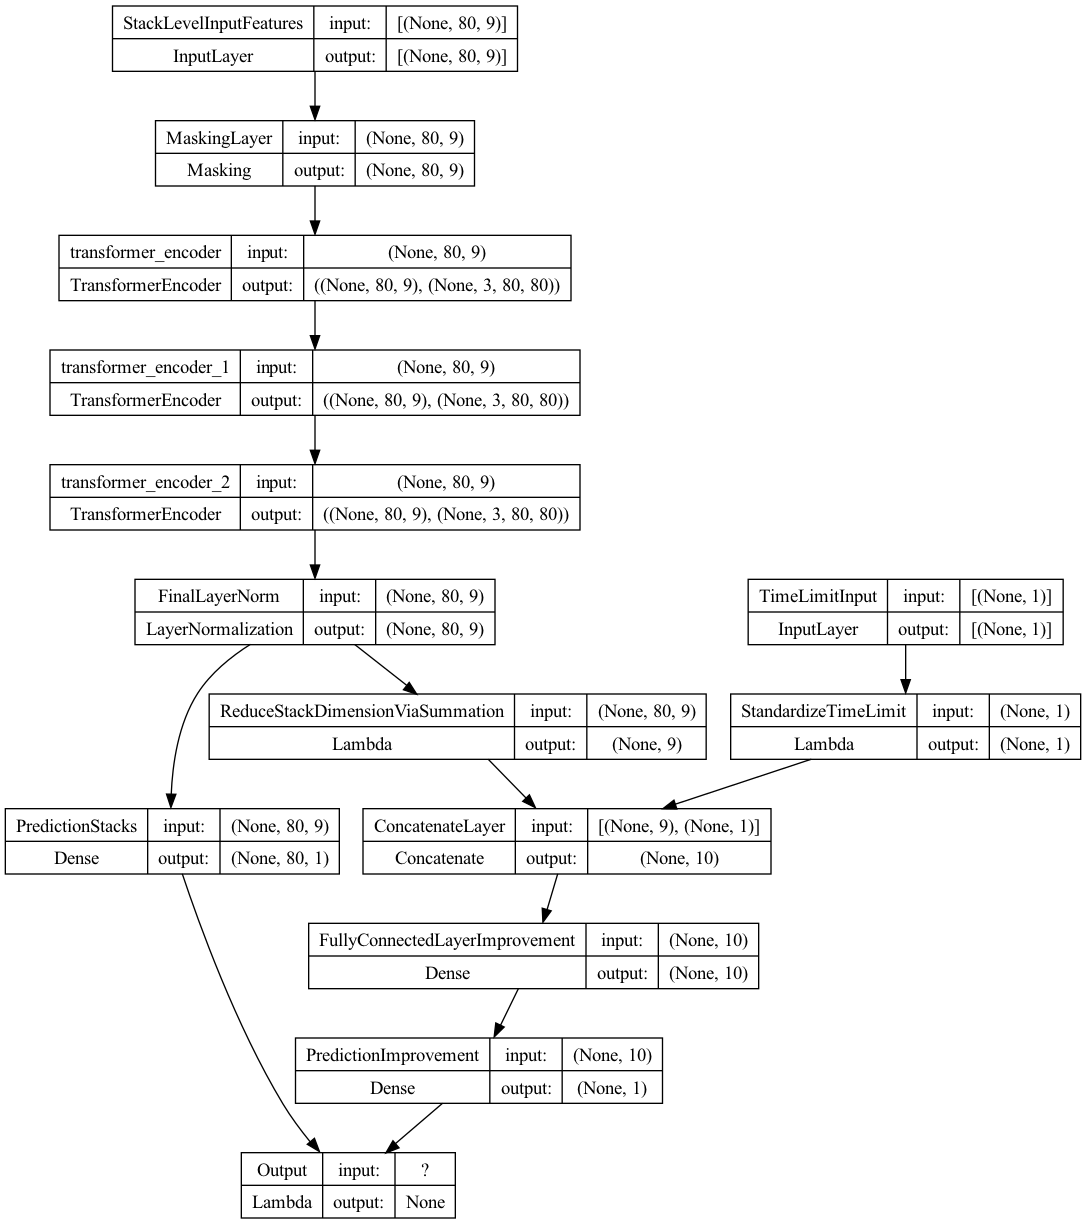

In [17]:
tf.keras.utils.plot_model(
    model,
    #to_file,
    show_shapes=True
)

## Training Process Functions

In [18]:
def geometric_decay(epoch: int, initial_lr:float=10e-3, lr_decay:float=0.9) -> float:
    """
    Exponential decay learning rate schedule
    """
    return initial_lr * lr_decay**epoch

#xx = np.arange(5000)
#yy = geometric_decay(xx, lr_decay=0.9995)
#plt.plot(xx, yy);

In [19]:
def early_stopping(track:pd.DataFrame, patience: int=1, metric: str="Val-Loss", target: str="Improvement") -> bool:
    """
    Early Stopping if no improvement in the metrics after 'patience' epochs.

    Assumes that the metrics is a loss to be minimized.

    TODO:
    -----
    - include option to check for increases in metric rather than just decreases
    """

    assert (type(patience) == int)
    assert (patience > 0)
    
    track = track.loc[(track["Metric"]==metric)&(track["Target"]==target), "Value"]
    
    current_value = track.iloc[-1]
    best_value = track.tail(patience).min() # plus1 since, last value is 'current_value', woudl always return True

    # Check if there is an improvement
    # since the current value could be the best
    # we need less or equal
    if current_value <= best_value:
        return False
    else:
        print(f"Early Stopping after no Improvement in {metric} for {target} after {patience} epochs")
        return True

    
    

In [20]:
def print_status_bar(iteration, total, losses, all_metrics=None, training:bool=True):
    tabs = "\t\t\t\t\t\t\t\t\t\t\t\t\t\t"
    metrics = tabs.join([
        f"{TARGET_LABELS[i]:<12}\tLoss: {losses[i].result():.4f}" +
        "\t".join([
            f"{m.name:>10}: {m.result():.2%}"
            if m.name not in ["MAE", "RMSE"]
            else f"{m.name:>10}: {m.result():.4f}"
            for m in metrics
        ])
        for i, metrics in enumerate(all_metrics)
    ])
    
    if training:
        prefix="Training"
    else:
        prefix="Validation"
    
    print(f"\r{prefix}-Iteration: {iteration+1:0>3}/{total:<3}\tLR: {float(optimizer.lr):<1000.9f}" + metrics,
          end="")


In [21]:
@tf.function
def model_pass(model, inputs, targets, training):
    """
    Usual Tensorflow model passing of inputs throught the network.
    If in training mode, the optimizier can apply the gradients
    observed with GradientTape to the model parameters
    """
    
    with tf.GradientTape() as tape:
        
        outputs = model(inputs, training=training)

        # Single output is not a list!
        if type(outputs) != list:
            outputs = [outputs]
            
        losses = [l(t, o) for l,o,t in zip(loss_objects, outputs, targets)]
        
        if training:
            gradients = tape.gradient(losses, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
        for i, mean_loss in enumerate(mean_losses):
            mean_loss(losses)
        
    return outputs


In [22]:
def run_epoch(model, dataset, target_labels, all_metrics:list[list[tf.keras.metrics]],
              epoch:int, history:pd.DataFrame, training:bool=True,
              shuffle:bool=True):
    """
    Single epoch, running several training steps over a dataset
    """

    for step, X_batch in enumerate(dataset):
        
        X_batch, y_batch = input_output_generation(
            X_batch,
            items=items,
            truck_stops=truck_stops,
            truck_dims=truck_dims,
            target_labels=target_labels,
            shuffle=shuffle,
            pad_size=PAD_SIZE
        )
        
        outputs = model_pass(model, X_batch, y_batch, training=training)
        
        for i, metrics in enumerate(all_metrics):
            for metric in metrics:
                metric(y_batch[i].reshape(-1), outputs[i].numpy().reshape(-1))
    
        print_status_bar(step, len(dataset), mean_losses, all_metrics, training=training)
    
        #### LEARNING RATE UPDATE ####
        if training:
            optimizer.lr = geometric_decay((epoch-1)*len(dataset)+step, initial_lr, lr_decay)
    
    print("\n")

    #### UPDATE METRICS
    for i, metrics in enumerate(all_metrics):
        for metric in metrics:
            data = pd.DataFrame({
                "Epoch": [epoch],
                "Target": [target_labels[i]],
                "Metric": [metric.name if training else f"Val-"+metric.name],
                "Value": [float(metric.result())],
            })
            history = pd.concat([history, data])
            metric.reset_states()

    for i, mean_loss in enumerate(mean_losses):
        data = pd.DataFrame({
            "Epoch": [epoch],
            "Target": [target_labels[i]],
            "Metric": ["Loss" if training else f"Val-"+"Loss"],
            "Value": [float(mean_loss.result())],
        })
        history = pd.concat([history, data])
        mean_loss.reset_states()
            
    return model, history

## Model Training

In [23]:
TARGET_LABELS = [
    "Solved",
    "Improvement",
    "AreaRatio",
    "Stacks"
]

n_epochs = 1
patience = 1

clms = ["Epoch", "Target", "Metric", "Value"]

tracks = []


for i, target_label_1 in enumerate(TARGET_LABELS):
    for j, target_label_2 in enumerate(TARGET_LABELS):
        
        if j > i:
            continue
        elif j==i:
            target_labels=[target_label_1]
        else:
            target_labels=[target_label_1, target_label_2]

        print(target_labels)
        
        track = pd.DataFrame(columns = clms)
        
        model = build_model(
            target_labels=target_labels
        )
    
        # get losses and metrics
        loss_objects = [target_loss_objects[target] for target in target_labels]
        mean_losses = [tf.keras.metrics.Mean(name=target) for target in target_labels]
        all_metrics = [all_target_metrics[target] for target in target_labels]
    
        @tf.function
        def model_pass(model, inputs, targets, training):
            """
            Usual Tensorflow model passing of inputs throught the network.
            If in training mode, the optimizier can apply the gradients
            observed with GradientTape to the model parameters
            """
            
            with tf.GradientTape() as tape:
                
                outputs = model(inputs, training=training)
        
                # Single output is not a list!
                if type(outputs) != list:
                    outputs = [outputs]
                    
                losses = [l(t, o) for l,o,t in zip(loss_objects, outputs, targets)]
                
                if training:
                    gradients = tape.gradient(losses, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    
                for i, mean_loss in enumerate(mean_losses):
                    mean_loss(losses)
                
            return outputs
    
        def run_epoch(model, dataset, target_labels, all_metrics:list[list[tf.keras.metrics]],
                      epoch:int, history:pd.DataFrame, training:bool=True,
                      shuffle:bool=True):
            """
            Single epoch, running several training steps over a dataset
            """
        
            for step, X_batch in enumerate(dataset):
                
                X_batch, y_batch = input_output_generation(
                    X_batch,
                    items=items,
                    truck_stops=truck_stops,
                    truck_dims=truck_dims,
                    target_labels=target_labels,
                    shuffle=shuffle,
                    pad_size=PAD_SIZE
                )
                
                outputs = model_pass(model, X_batch, y_batch, training=training)
                
                for i, metrics in enumerate(all_metrics):
                    for metric in metrics:
                        metric(y_batch[i].reshape(-1), outputs[i].numpy().reshape(-1))
            
                print_status_bar(step, len(dataset), mean_losses, all_metrics, training=training)
            
                #### LEARNING RATE UPDATE ####
                if training:
                    optimizer.lr = geometric_decay((epoch-1)*len(dataset)+step, initial_lr, lr_decay)
            
            print("\n")
        
            #### UPDATE METRICS
            for i, metrics in enumerate(all_metrics):
                for metric in metrics:
                    data = pd.DataFrame({
                        "Epoch": [epoch],
                        "Target": [target_labels[i]],
                        "Metric": [metric.name if training else f"Val-"+metric.name],
                        "Value": [float(metric.result())],
                    })
                    history = pd.concat([history, data])
                    metric.reset_states()
        
            for i, mean_loss in enumerate(mean_losses):
                data = pd.DataFrame({
                    "Epoch": [epoch],
                    "Target": [target_labels[i]],
                    "Metric": ["Loss" if training else f"Val-"+"Loss"],
                    "Value": [float(mean_loss.result())],
                })
                history = pd.concat([history, data])
                mean_loss.reset_states()
                    
            return model, history
    
    
        for epoch in range(1, n_epochs+1):
            
            print(f"Epoch {epoch:0>3}/{ n_epochs:0>3}")
        
            model, track = run_epoch(model, train_dataset, target_labels,
                                     all_metrics, epoch=epoch, history=track, training=True, shuffle=True)
            model, track = run_epoch(model, val_dataset, target_labels,
                                     all_metrics, epoch=epoch, history=track, training=False, shuffle=True)
        
            # make an intermediate save of the model
            model_path = os.path.join(cwd, "models", "01_Multitask", f"{target_label_1}-{target_label_2}-MODEL.tf")
            model.save(model_path, overwrite=True, save_format="tf")
        
            # Early Stopping
            #if early_stopping(track, patience=patience):
            #    break
        
            print("-"*120)
    
        tracks.append(track)
        
        

['Solved']
Epoch 001/001


2023-12-18 07:57:47.794416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Training-Iteration: 479/479	LR: 0.007877617                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_67166/2949534318.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, data])


Validation-Iteration: 114/114	LR: 0.007873679                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/01_Multitask/Solved-Solved-MODEL.tf/assets


------------------------------------------------------------------------------------------------------------------------
['Improvement', 'Solved']
Epoch 001/001
Training-Iteration: 479/479	LR: 0.007877617                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_67166/2949534318.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, data])


Validation-Iteration: 114/114	LR: 0.007873679                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/01_Multitask/Improvement-Solved-MODEL.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/01_Multitask/Improvement-Solved-MODEL.tf/assets


------------------------------------------------------------------------------------------------------------------------
['Improvement']
Epoch 001/001
Training-Iteration: 479/479	LR: 0.007877617                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_67166/2949534318.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, data])


Validation-Iteration: 114/114	LR: 0.007873679                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/01_Multitask/Improvement-Improvement-MODEL.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/01_Multitask/Improvement-Improvement-MODEL.tf/assets


------------------------------------------------------------------------------------------------------------------------
['AreaRatio', 'Solved']
Epoch 001/001
Training-Iteration: 479/479	LR: 0.007877617                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_67166/2949534318.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, data])


Validation-Iteration: 114/114	LR: 0.007873679                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/01_Multitask/AreaRatio-Solved-MODEL.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/01_Multitask/AreaRatio-Solved-MODEL.tf/assets


------------------------------------------------------------------------------------------------------------------------
['AreaRatio', 'Improvement']
Epoch 001/001
Training-Iteration: 479/479	LR: 0.007877617                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_67166/2949534318.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, data])


Validation-Iteration: 114/114	LR: 0.007873679                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/01_Multitask/AreaRatio-Improvement-MODEL.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/01_Multitask/AreaRatio-Improvement-MODEL.tf/assets


------------------------------------------------------------------------------------------------------------------------
['AreaRatio']
Epoch 001/001
Training-Iteration: 479/479	LR: 0.007877617                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_67166/2949534318.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, data])


Validation-Iteration: 114/114	LR: 0.007873679                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/01_Multitask/AreaRatio-AreaRatio-MODEL.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/01_Multitask/AreaRatio-AreaRatio-MODEL.tf/assets


------------------------------------------------------------------------------------------------------------------------
['Stacks', 'Solved']
Epoch 001/001
Training-Iteration: 479/479	LR: 0.007877617                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_67166/2949534318.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, data])


Validation-Iteration: 114/114	LR: 0.007873679                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/01_Multitask/Stacks-Solved-MODEL.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/01_Multitask/Stacks-Solved-MODEL.tf/assets


------------------------------------------------------------------------------------------------------------------------
['Stacks', 'Improvement']
Epoch 001/001
Training-Iteration: 479/479	LR: 0.007877617                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_67166/2949534318.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, data])


Validation-Iteration: 114/114	LR: 0.007873679                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/01_Multitask/Stacks-Improvement-MODEL.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/01_Multitask/Stacks-Improvement-MODEL.tf/assets


------------------------------------------------------------------------------------------------------------------------
['Stacks', 'AreaRatio']
Epoch 001/001
Training-Iteration: 479/479	LR: 0.007877617                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_67166/2949534318.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, data])


Validation-Iteration: 114/114	LR: 0.007873679                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/01_Multitask/Stacks-AreaRatio-MODEL.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/01_Multitask/Stacks-AreaRatio-MODEL.tf/assets


------------------------------------------------------------------------------------------------------------------------
['Stacks']
Epoch 001/001
Training-Iteration: 479/479	LR: 0.007877617                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_67166/2949534318.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, data])


Validation-Iteration: 114/114	LR: 0.007873679                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/01_Multitask/Stacks-Stacks-MODEL.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/01_Multitask/Stacks-Stacks-MODEL.tf/assets


------------------------------------------------------------------------------------------------------------------------


# Cunfusion Matrices:

## ACC and RMSE

In [26]:
TARGET_LABELS

['Solved', 'Improvement', 'AreaRatio', 'Stacks']

In [121]:
val_accuracies = pd.DataFrame(
    [
        [84.20, 75.18, 0.0407, 98.24], # trained with solved (ACC, ACC, RMSE, ACC)
        [82.82, 73.30, 0.0458, 98.24], # trained with Improvement
        [82.37, 71.66, 0.0404, 98.53], # trained with AreaRatio
        [81.42, 69.66, 0.0406, 98.62], # trained with Stacks
    ],
    index=TARGET_LABELS,
    columns=TARGET_LABELS

)
val_accuracies

,Solved,Improvement,AreaRatio,Stacks
Solved,84.20,75.18,0.0407,98.24
Improvement,82.82,73.30,0.0458,98.24
AreaRatio,82.37,71.66,0.0404,98.53
Stacks,81.42,69.66,0.0406,98.62


In [122]:
diag = np.diagonal(val_accuracies)
val_accuracies = val_accuracies / diag
val_accuracies = val_accuracies-1
val_accuracies = val_accuracies*100
val_accuracies["AreaRatio"] = -val_accuracies["AreaRatio"]
val_accuracies

,Solved,Improvement,AreaRatio,Stacks
Solved,0.000000,2.564802,-0.742574,-0.385317
Improvement,-1.638955,0.000000,-13.366337,-0.385317
AreaRatio,-2.173397,-2.237381,-0.000000,-0.091259
Stacks,-3.301663,-4.965894,-0.495050,0.000000


In [123]:
val_accuracies.loc["Average",:] = val_accuracies.replace(0, np.nan).mean(axis=0)
val_accuracies.loc[:,"Average"] = val_accuracies.replace(0, np.nan).mean(axis=1)
val_accuracies

,Solved,Improvement,AreaRatio,Stacks,Average
Solved,0.000000,2.564802,-0.742574,-0.385317,0.478970
Improvement,-1.638955,0.000000,-13.366337,-0.385317,-5.130203
AreaRatio,-2.173397,-2.237381,-0.000000,-0.091259,-1.500679
Stacks,-3.301663,-4.965894,-0.495050,0.000000,-2.920869
Average,-2.371338,-1.546157,-4.867987,-0.287298,-2.268195


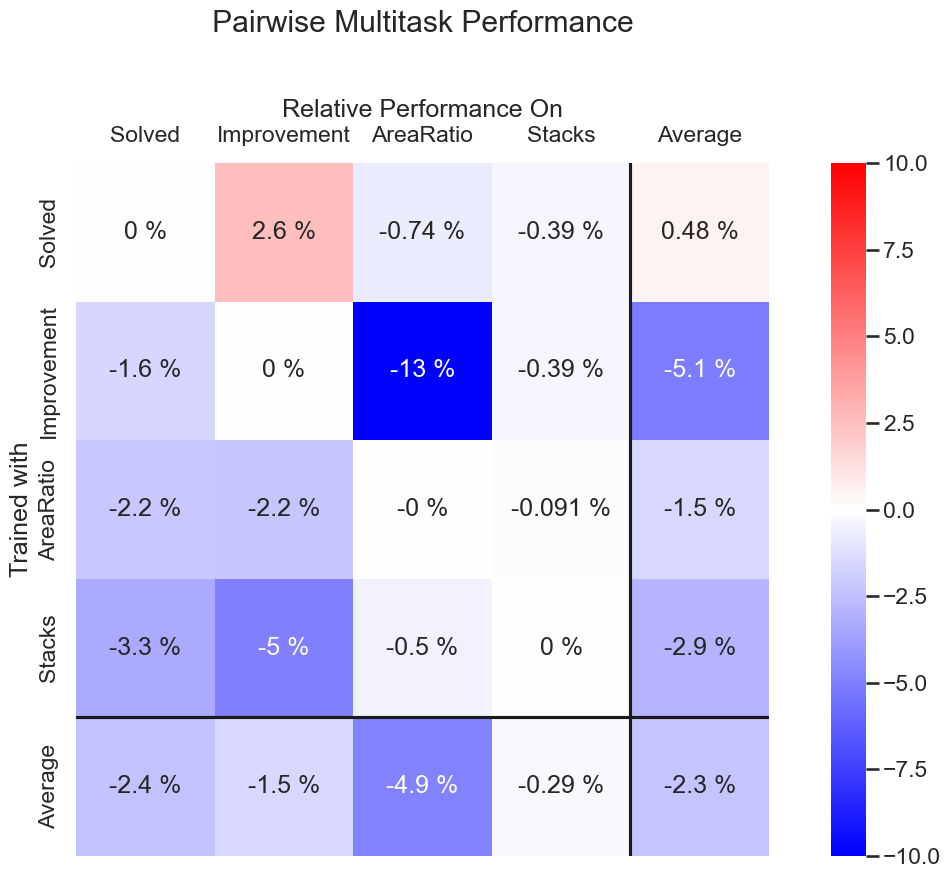

In [139]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(
    val_accuracies,
    cmap="bwr",
    vmin=-10,vmax=10,
    square=True,
    cbar=True,
    annot=True,
    #annot=val_accuracies_str
    ax=ax
);
ax.set(
    ylabel="Trained with",
    title="Relative Performance On"
)
ax.xaxis.tick_top()
ax.xaxis.set_ticks_position('none') 
#ax.set_xticks(np.arange(4) + 0.5, minor=False)
ax.set_xticklabels(TARGET_LABELS+["Average"], minor=False);
ax.axvline(4, c="k");
ax.axhline(4, c="k");

for t in ax.texts: t.set_text(t.get_text() + " %")
fig.suptitle("           Pairwise Multitask Performance", y=1.05);

#plt.ticks_position('top')
figure_path=os.path.join(cwd, "plots", "2023-12-16-MultitaskTraining", "MultitaskMatrixACC+RMSE.png")
plt.savefig(figure_path)
figure_path=os.path.join(cwd, "plots", "2023-12-16-MultitaskTraining", "MultitaskMatrixACC+RMSE.jpg")
plt.savefig(figure_path)
figure_path=os.path.join(cwd, "plots", "2023-12-16-MultitaskTraining", "MultitaskMatrixACC+RMSE.pdf")
plt.savefig(figure_path)
figure_path=os.path.join(cwd, "plots", "2023-12-16-MultitaskTraining", "MultitaskMatrixACC+RMSE.svg")
plt.savefig(figure_path)

## AUC and MAE:

In [117]:
val_average_precisions = pd.DataFrame(
    [
        [91.09, 81.18, 0.0278, 16.26], # trained with solved (ACC, ACC, RMSE, ACC)
        [89.26, 79.65, 0.0336,  9.17], # trained with Improvement
        [89.25, 76.46, 0.0257, 45.48], # trained with AreaRatio
        [89.34, 72.79, 0.0268, 55.23], # trained with Stacks
    ],
    index=TARGET_LABELS,
    columns=TARGET_LABELS

)
val_average_precisions

,Solved,Improvement,AreaRatio,Stacks
Solved,91.09,81.18,0.0278,16.26
Improvement,89.26,79.65,0.0336,9.17
AreaRatio,89.25,76.46,0.0257,45.48
Stacks,89.34,72.79,0.0268,55.23


In [118]:
diag = np.diagonal(val_average_precisions)
val_average_precisions = val_average_precisions / diag
val_average_precisions = val_average_precisions-1
val_average_precisions = val_average_precisions*100
val_average_precisions["AreaRatio"] = -val_average_precisions["AreaRatio"]
val_average_precisions

,Solved,Improvement,AreaRatio,Stacks
Solved,0.000000,1.920904,-8.171206,-70.559479
Improvement,-2.009002,0.000000,-30.739300,-83.396705
AreaRatio,-2.019980,-4.005022,-0.000000,-17.653449
Stacks,-1.921177,-8.612680,-4.280156,0.000000


In [119]:
val_average_precisions.loc["Average",:] = val_average_precisions.replace(0, np.nan).mean(axis=0)
val_average_precisions.loc[:,"Average"] = val_average_precisions.replace(0, np.nan).mean(axis=1)
val_average_precisions

,Solved,Improvement,AreaRatio,Stacks,Average
Solved,0.000000,1.920904,-8.171206,-70.559479,-25.603260
Improvement,-2.009002,0.000000,-30.739300,-83.396705,-38.715002
AreaRatio,-2.019980,-4.005022,-0.000000,-17.653449,-7.892817
Stacks,-1.921177,-8.612680,-4.280156,0.000000,-4.938004
Average,-1.983386,-3.565599,-14.396887,-57.203211,-19.287271


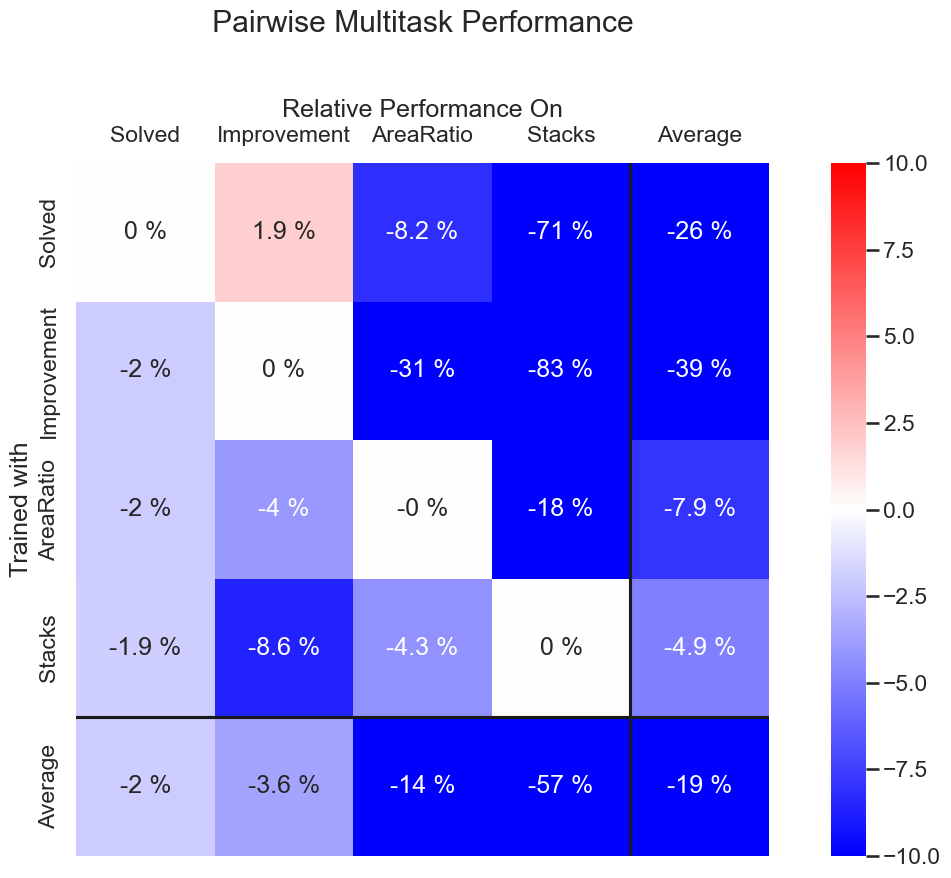

In [140]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(
    val_average_precisions,
    cmap="bwr",
    vmin=-10,vmax=10,
    square=True,
    cbar=True,
    annot=True,
    #annot=val_accuracies_str
    ax=ax
);
ax.set(
    ylabel="Trained with",
    title="Relative Performance On"
)
ax.xaxis.tick_top()
ax.xaxis.set_ticks_position('none') 
#ax.set_xticks(np.arange(4) + 0.5, minor=False)
ax.set_xticklabels(TARGET_LABELS+["Average"], minor=False);
ax.axvline(4, c="k");
ax.axhline(4, c="k");

for t in ax.texts: t.set_text(t.get_text() + " %")
fig.suptitle("           Pairwise Multitask Performance", y=1.05);

#plt.ticks_position('top')
figure_path=os.path.join(cwd, "plots", "2023-12-16-MultitaskTraining", "MultitaskMatrixAUC+MAE.png")
plt.savefig(figure_path)
figure_path=os.path.join(cwd, "plots", "2023-12-16-MultitaskTraining", "MultitaskMatrixAUC+MAE.jpg")
plt.savefig(figure_path)
figure_path=os.path.join(cwd, "plots", "2023-12-16-MultitaskTraining", "MultitaskMatrixAUC+MAE.pdf")
plt.savefig(figure_path)
figure_path=os.path.join(cwd, "plots", "2023-12-16-MultitaskTraining", "MultitaskMatrixAUC+MAE.svg")
plt.savefig(figure_path)

In [ ]:
from utils.DNN.utils import get_attention_scores

attention = get_attention_scores(model, model_inputs=cx, layer_name=f"transformer_encoder_{n_blocks-1}")
attention.shape
#cx[0][24].round(2)[:40]

In [ ]:
instance, head = 24, 1 # 18: 36 # 24 is a very simple but good example
head = min(head, num_heads-1)

attention_matrix = attention[instance, head, :, :]

# truncate:
n_inputs = np.argmax(np.all(cx[0][instance].round(2) == 0, axis=1))
attention_matrix = attention_matrix[:n_inputs, :n_inputs]

plt.figure(figsize=(12, 12))
sns.heatmap(attention_matrix.T,
            square=True,
            #vmin=0, vmax=1
           );

In [ ]:
instances = [28, 24, 25, 26]
heads = list(range(num_heads))

fig, ax = plt.subplots(len(instances), num_heads, figsize=(16, len(instances)*5))

for i, instance in enumerate(instances):
    for h, head in enumerate(heads):

        # Truncate
        attention_matrix = attention[instance, head, :, :]
        n_inputs = np.argmax(np.all(cx[0][instance].round(2) == 0, axis=1))
        attention_matrix = attention_matrix[:n_inputs, :n_inputs]
        
        sns.heatmap(
            attention_matrix.T,
            square=True,
            cbar=False,
            #vmin=0, vmax=0.1,
            ax=ax[i, h]
        );